## Network Model of the NYC Subway Network with IBX Stations

### Constructing the Network

#### Nodes

In [4]:
#add necessary libraries
import networkx as nx #library supporting networks
import matplotlib.pyplot as plt #plotting
import pandas as pd
import numpy as np
import scipy.stats as stat
#make sure plots are embedded into the notebook
%matplotlib inline 
#pd.set_option('max_columns',None)

In [5]:
#station list, with IBX stations encoded
Stations = pd.read_csv('Stations_woIBX.csv', index_col=0, header=0)
Stations

,name,id,boro,lat,long,lines
0,Greenpoint Av,G26,Bk,40.731352,-73.954449,G
1,21 St,G24,Q,40.744065,-73.949724,G
2,Court Sq,G22,Q,40.746554,-73.943832,G
3,36 St,G20,Q,40.752039,-73.928781,M R
4,Queens Plaza,G21,Q,40.748973,-73.937243,E M R
...,...,...,...,...,...,...
493,City Hall,R24,M,40.713282,-74.006978,R W
494,Canal St,R23,M,40.719527,-74.001775,R W
495,Prince St,R22,M,40.724329,-73.997702,R W
496,8 St - NYU,R21,M,40.730328,-73.992629,R W


In [6]:
#filter out Staten Island, as its rail network is unconnected with the rest of the network
Stations = Stations.loc[Stations['boro'] != 'SI']

In [7]:
#for mega-stations (complexes) which are currently represented as 2 separate station nodes, we need to create 1 new node to connect them to each
#other and serve as the station node for subsequent analysis. We will use the Complex ID
sts = pd.read_csv(r'..\Turnstile Data Processing\stations_list (1).csv')
sts.head()

,Unnamed: 0,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Direction Notes,ADA NB,ADA SB,Capital Outage NB,Capital Outage SB
0,118,119,119,L06,BMT,Canarsie,1 AV,M,L,Subway,40.730953,-73.981628,8 Av,Brooklyn,1,NaN,NaN,NaN,NaN,NaN
1,395,395,395,624,IRT,Lexington Av,103 ST,M,6,Subway,40.790600,-73.947478,Uptown & The Bronx,Downtown,0,NaN,NaN,NaN,NaN,NaN
2,155,156,156,A18,IND,8th Av - Fulton St,103 ST,M,B C,Subway,40.796092,-73.961454,Uptown & The Bronx,Downtown & Brooklyn,0,NaN,NaN,NaN,NaN,NaN
3,309,309,309,119,IRT,Broadway - 7Av,103 ST,M,1,Subway,40.799446,-73.968379,Uptown & The Bronx,Downtown,0,NaN,NaN,NaN,NaN,NaN
4,450,450,450,706,IRT,Flushing,103 ST-CORONA PLAZA,Q,7,Elevated,40.749865,-73.862700,Flushing,Manhattan,0,NaN,NaN,NaN,NaN,NaN


In [8]:
#check the merge
Stations = pd.merge(Stations, sts[['GTFS Stop ID','Complex ID']], how='left',left_on='id',right_on='GTFS Stop ID', indicator=True)
Stations._merge.value_counts()

both          474
left_only       1
right_only      0
Name: _merge, dtype: int64

In [9]:
#only one missing merge, the South Ferry Loop, id 140.
Stations[Stations._merge == 'left_only']

,name,id,boro,lat,long,lines,GTFS Stop ID,Complex ID,_merge
109,South Ferry Loop,140,M,40.701411,-74.013205,1,NaN,NaN,left_only


In [10]:
#manually set South Ferry Loop Complex ID to 635
Stations.loc[Stations['name'] == 'South Ferry Loop','Complex ID'] = 635

Stations['Complex ID'].fillna(0,inplace=True)
Stations['Complex ID'] = Stations['Complex ID'].astype(int)

#drop the unnecessary columns
Stations.drop(['_merge','GTFS Stop ID'],axis=1,inplace=True)
Stations.head()

,name,id,boro,lat,long,lines,Complex ID
0,Greenpoint Av,G26,Bk,40.731352,-73.954449,G,283
1,21 St,G24,Q,40.744065,-73.949724,G,282
2,Court Sq,G22,Q,40.746554,-73.943832,G,606
3,36 St,G20,Q,40.752039,-73.928781,M R,272
4,Queens Plaza,G21,Q,40.748973,-73.937243,E M R,273


In [11]:
#Split the lines into multiple columns
Stations = Stations.join(Stations['lines'].str.split(' ', expand=True)).rename({0:'line_1',1:'line_2',2:'line_3',3:'line_4'}, axis=1)
Stations

,name,id,boro,lat,long,lines,Complex ID,line_1,line_2,line_3,line_4
0,Greenpoint Av,G26,Bk,40.731352,-73.954449,G,283,G,None,None,None
1,21 St,G24,Q,40.744065,-73.949724,G,282,G,None,None,None
2,Court Sq,G22,Q,40.746554,-73.943832,G,606,G,None,None,None
3,36 St,G20,Q,40.752039,-73.928781,M R,272,M,R,None,None
4,Queens Plaza,G21,Q,40.748973,-73.937243,E M R,273,E,M,R,None
...,...,...,...,...,...,...,...,...,...,...,...
470,City Hall,R24,M,40.713282,-74.006978,R W,20,R,W,None,None
471,Canal St,R23,M,40.719527,-74.001775,R W,623,R,W,None,None
472,Prince St,R22,M,40.724329,-73.997702,R W,17,R,W,None,None
473,8 St - NYU,R21,M,40.730328,-73.992629,R W,16,R,W,None,None


In [12]:
#For stations with more than 1 line, unpivot to create new rows.
stli = pd.wide_to_long(Stations, stubnames='line_',i='id',j='station_line').sort_index(level=0)
stli.dropna(inplace=True)
stli.reset_index(inplace=True)
stli.rename({'id':'station_id'},axis=1,inplace=True)
stli

,station_id,station_line,boro,lat,name,Complex ID,long,lines,line_
0,101,1,Bx,40.889248,Van Cortlandt Park - 242 St,293,-73.898583,1,1
1,103,1,Bx,40.884667,238 St,294,-73.900870,1,1
2,104,1,Bx,40.878856,231 St,295,-73.904834,1,1
3,106,1,M,40.874561,Marble Hill - 225 St,296,-73.909831,1,1
4,107,1,M,40.869444,215 St,297,-73.915279,1,1
...,...,...,...,...,...,...,...,...,...
744,R44,1,Bk,40.622687,86 St,38,-74.028398,R,R
745,R45,1,Bk,40.616622,Bay Ridge - 95 St,39,-74.030876,R,R
746,S01,1,Bk,40.680596,Franklin Av,627,-73.955827,S,S
747,S03,1,Bk,40.674772,Park Pl,141,-73.957624,S,S


In [13]:
#each station-line has 2 platforms for trains going in both directions, so we can duplicate the table
pfs = pd.concat([stli]*2)
#create a new columns to distinguish north and south-bound trains, add South designation to half of the rows
pfs['dir'] = 'N'
pfs.iloc[:stli.shape[0],9] = 'S'
pfs

,station_id,station_line,boro,lat,name,Complex ID,long,lines,line_,dir
0,101,1,Bx,40.889248,Van Cortlandt Park - 242 St,293,-73.898583,1,1,S
1,103,1,Bx,40.884667,238 St,294,-73.900870,1,1,S
2,104,1,Bx,40.878856,231 St,295,-73.904834,1,1,S
3,106,1,M,40.874561,Marble Hill - 225 St,296,-73.909831,1,1,S
4,107,1,M,40.869444,215 St,297,-73.915279,1,1,S
...,...,...,...,...,...,...,...,...,...,...
744,R44,1,Bk,40.622687,86 St,38,-74.028398,R,R,N
745,R45,1,Bk,40.616622,Bay Ridge - 95 St,39,-74.030876,R,R,N
746,S01,1,Bk,40.680596,Franklin Av,627,-73.955827,S,S,N
747,S03,1,Bk,40.674772,Park Pl,141,-73.957624,S,S,N


In [14]:
#create platform_id field based on station_id + line + dir
pfs['pf_id'] = pfs['station_id'] + '-' + pfs['line_'] + '-' + pfs['dir']
pfs

,station_id,station_line,boro,lat,name,Complex ID,long,lines,line_,dir,pf_id
0,101,1,Bx,40.889248,Van Cortlandt Park - 242 St,293,-73.898583,1,1,S,101-1-S
1,103,1,Bx,40.884667,238 St,294,-73.900870,1,1,S,103-1-S
2,104,1,Bx,40.878856,231 St,295,-73.904834,1,1,S,104-1-S
3,106,1,M,40.874561,Marble Hill - 225 St,296,-73.909831,1,1,S,106-1-S
4,107,1,M,40.869444,215 St,297,-73.915279,1,1,S,107-1-S
...,...,...,...,...,...,...,...,...,...,...,...
744,R44,1,Bk,40.622687,86 St,38,-74.028398,R,R,N,R44-R-N
745,R45,1,Bk,40.616622,Bay Ridge - 95 St,39,-74.030876,R,R,N,R45-R-N
746,S01,1,Bk,40.680596,Franklin Av,627,-73.955827,S,S,N,S01-S-N
747,S03,1,Bk,40.674772,Park Pl,141,-73.957624,S,S,N,S03-S-N


In [15]:
#let's change the lat-long slightly for the platforms so they aren't totally on top of each other. this is not meant to be geographically accurate!
#offset the 1st platform from the station by .0006 degrees lat, which is about 200 feet north
pfs.loc[pfs.station_line ==1,'lat'] = pfs.loc[pfs.station_line ==1,'lat'] + .0006
pfs.loc[pfs.station_line ==2,'long'] = pfs.loc[pfs.station_line ==2,'long'] + .0006 #offset to east
pfs.loc[pfs.station_line ==3,'lat'] = pfs.loc[pfs.station_line ==3,'lat'] - .0006  #offset to south
pfs.loc[pfs.station_line ==4,'long'] = pfs.loc[pfs.station_line ==4,'long'] - .0006 #offset to west

#and let's offset the north platforms from the south by adding .0001 degrees lat or ~35 feet north
pfs.loc[pfs.dir =='N','lat'] = pfs.loc[pfs.dir =='N','lat'] + .0006


In [16]:
#finally, let's concatenate the stations to the platforms
Stations.rename({'id':'station_id','lines':'line_'},axis=1,inplace=True)
Stations.drop(['line_1','line_2','line_3','line_4'],axis = 1,inplace=True)
Stations[['pf_id','dir','station_line']] = 'station'
nodes = pd.concat([pfs,Stations])

In [17]:
#we need to create a few extra nodes for the super stations that share a complex ID, but have separate station nodes
#groupby complex id and take the average lat/long to place the complex in the middle of the stations
#then filter for only complexes that have more than 1 station
cid = Stations[['Complex ID','station_id','lat','long','boro','name']] \
    .groupby(['Complex ID']).agg({'station_id':'count','lat':'mean','long':'mean','boro':'min','name':'min'}) \
    .sort_values(by='station_id',ascending=False)
    
cid = cid[cid['station_id'] >1]
cid

,station_id,lat,long,boro,name
Complex ID,,,,,
611,5,40.755746,-73.987581,M,42 St - Port Authority Bus Terminal
628,4,40.710089,-74.007838,M,Fulton St
624,4,40.712603,-74.009552,M,Chambers St
623,4,40.718701,-74.000580,M,Canal St
621,3,40.678896,-73.904356,Bk,Broadway Jct
620,3,40.693241,-73.990642,Bk,Borough Hall
610,3,40.751992,-73.977359,M,Grand Central - 42 St
617,3,40.684162,-73.977789,Bk,Atlantic Av - Barclays Ctr
606,3,40.747141,-73.945032,Q,Court Sq


In [18]:
#create a new dataframe for these complexes
cid_df = pd.DataFrame(columns = nodes.columns)
cid_df['Complex ID'] = cid.index
cid_df['lat'] = cid['lat'].values
cid_df['long'] = cid['long'].values
cid_df['boro'] = cid['boro'].values
cid_df['name'] = cid['name'].values
cid_df[['station_id','station_line','lines','line_','dir','pf_id']] = 'complex'
cid_df

,station_id,station_line,boro,lat,name,Complex ID,long,lines,line_,dir,pf_id
0,complex,complex,M,40.755746,42 St - Port Authority Bus Terminal,611,-73.987581,complex,complex,complex,complex
1,complex,complex,M,40.710089,Fulton St,628,-74.007838,complex,complex,complex,complex
2,complex,complex,M,40.712603,Chambers St,624,-74.009552,complex,complex,complex,complex
3,complex,complex,M,40.718701,Canal St,623,-74.000580,complex,complex,complex,complex
4,complex,complex,Bk,40.678896,Broadway Jct,621,-73.904356,complex,complex,complex,complex
5,complex,complex,Bk,40.693241,Borough Hall,620,-73.990642,complex,complex,complex,complex
6,complex,complex,M,40.751992,Grand Central - 42 St,610,-73.977359,complex,complex,complex,complex
7,complex,complex,Bk,40.684162,Atlantic Av - Barclays Ctr,617,-73.977789,complex,complex,complex,complex
8,complex,complex,Q,40.747141,Court Sq,606,-73.945032,complex,complex,complex,complex
9,complex,complex,M,40.735066,14 St - Union Sq,602,-73.990416,complex,complex,complex,complex


In [19]:
#merge complexes into nodes
nodes = pd.concat([nodes,cid_df])
nodes.shape

(2008, 11)

In [20]:
nodes['node_id'] = ''
nodes.reset_index(inplace=True,drop=True)
for i in nodes.index:
    if ((nodes.loc[i,'pf_id'] != 'station') & (nodes.loc[i,'pf_id'] != 'complex')):
        nodes.loc[i,'node_id'] = nodes.loc[i,'pf_id']
    elif nodes.loc[i,'pf_id'] != 'complex':
        nodes.loc[i,'node_id'] = nodes.loc[i,'station_id']
    else:
        nodes.loc[i,'node_id'] = str(nodes.loc[i,'Complex ID']) + 'c'

nodes

,station_id,station_line,boro,lat,name,Complex ID,long,lines,line_,dir,pf_id,node_id
0,101,1,Bx,40.889848,Van Cortlandt Park - 242 St,293,-73.898583,1,1,S,101-1-S,101-1-S
1,103,1,Bx,40.885267,238 St,294,-73.900870,1,1,S,103-1-S,103-1-S
2,104,1,Bx,40.879456,231 St,295,-73.904834,1,1,S,104-1-S,104-1-S
3,106,1,M,40.875161,Marble Hill - 225 St,296,-73.909831,1,1,S,106-1-S,106-1-S
4,107,1,M,40.870044,215 St,297,-73.915279,1,1,S,107-1-S,107-1-S
...,...,...,...,...,...,...,...,...,...,...,...,...
2003,complex,complex,M,40.718463,Delancey St,625,-73.987775,complex,complex,complex,complex,625c
2004,complex,complex,Bk,40.670513,Botanic Garden,626,-73.958688,complex,complex,complex,complex,626c
2005,complex,complex,Bk,40.680988,Franklin Av,627,-73.956337,complex,complex,complex,complex,627c
2006,complex,complex,Bk,40.713428,Lorimer St,629,-73.950847,complex,complex,complex,complex,629c


In [21]:
#prep export file with only the stations and complexes, excluding stations that are inside of a complex
#remove platform edges
nodes_export = nodes[(nodes['pf_id'] == 'station') | (nodes['pf_id'] == 'complex')]
#only keep rows if they are a complex or they are stations but not part of a complex in the complex list
nodes_export = nodes_export.loc[(nodes_export['station_id'] == 'complex') | ~(nodes_export['Complex ID'].isin(cid.index)),:]
nodes_export.shape

(424, 12)

In [22]:
nodes_export['node_id'].nunique()

424

In [23]:
#export to csv
#nodes_export.to_csv('station_complex_nodes.csv')

#### Edges

Next step is edges. the edge list actually shows multiple edges for each line and direction. for example, station 230 (Wall Street) 
and station 231 (Clark Street) are already connected by 4 edges: the 2 and 3 trains, northbound and southbound. However, because the stations are represented as single nodes, these 4 edges are indistinguishable from one another, and networkx only uses 1 of them anyway.

So for each of these existing edges, we need to reset the origin and destination based on the platform_id. In the example above, we need to end up with the following edges:
* 230-2-S --> 231-2-S
* 230-3-S --> 231-3-S
* 231-2-N --> 230-2-N
* 231-3-N --> 230-3-N

Actually, we don't need this to be a directed graph, so don't worry if northbound edges are going south.But it is important that only edges with the same line and direction are connected. So we can't have a southbound train going to a northbound platform, and we can't have a 2 train going to a 3 platform (even though in actuality they do share a platform).

So basically, for each unique origin and destination in the edge list, we need to look up the lines that are serving both of those stations. If the stations have line(s) in common, we draw an edge between the corresponding platforms in both directions

I think the easiest way to do this in practice is to add a bunch of columns to the edge list, for each of the ~31 subway lines
If both the origin and destination of the edge contain the same line, mark that as a 1, otherwise if one/both doesn't have that line mark 0.


In [24]:
#connection list, with IBX connections encoded
Links = pd.read_csv('Links_wIBX.csv', index_col=0, header=0)
Links.head()

,origin,dest
0,G26,G24
1,G26,G28
2,G24,G26
3,G24,G22
4,G22,G24


In [25]:
#Filter out connectiosn associated with the IBX in the Links dataset -> indices 1848 to 1865 are IBX related
Links = Links.loc[~Links.index.isin(np.arange(1848,1866))].reset_index(drop = True)

In [26]:
#the repeated edges are of no use to us, so let's get unique edges.
uLinks = Links.drop_duplicates().reset_index()
uLinks.drop('index',axis=1,inplace=True)
uLinks.shape

(1227, 2)

In [27]:
#get the links for the Prospect Park Shuttle
S_links = uLinks.loc[(uLinks['origin'].isin(['S01', 'S03', 'S04'])) | \
    (uLinks['dest'].isin(['S01', 'S03', 'S04']))]

S_links

,origin,dest
154,A45,S01
237,239,S04
1077,D26,S04
1107,S01,S03
1108,S01,A45
1109,S03,S01
1110,S03,S04
1111,S04,S03
1112,S04,239
1113,S04,D26


In [28]:
#drop links from Staten Island, concatenate Shuttle links back in (since they get dropped here)
uLinks = uLinks.loc[(~uLinks['origin'].str.startswith('S')) | (~uLinks['dest'].str.startswith('S'))]

uLinks = pd.concat([uLinks, S_links], ignore_index=True)
uLinks

,origin,dest
0,G26,G24
1,G26,G28
2,G24,G26
3,G24,G22
4,G22,G24
...,...,...
1184,S03,S01
1185,S03,S04
1186,S04,S03
1187,S04,239


In [29]:
#Also, we don't need a directed graph because we will incorporate that logic into the platforms, i.e. only northbound platforms can have an edge, but the direction of that edge
#isn't important. If the northbound edges are actually going south geographically, it doesn't make a difference. So let's remove duplicate edges that are A-->B and B-->A
uuLinks = uLinks[~pd.DataFrame(np.sort(uLinks[['origin','dest']].values,1)).duplicated()].sort_values('origin')
uuLinks.reset_index(inplace=True)
uuLinks

,index,origin,dest
0,126,103,104
1,125,103,101
2,129,106,104
3,128,106,107
4,121,108,109
...,...,...,...
595,526,R43,R44
596,527,R43,R42
597,670,R45,R44
598,1182,S01,S03


In [30]:
d = pd.DataFrame(np.zeros((uuLinks.shape[0], pfs.line_.nunique())))
d.columns = pfs.line_.unique()
uuLinks = pd.concat([uuLinks,d],axis=1)
uuLinks

,index,origin,dest,1,2,3,5,4,6,7,...,F,G,Q,M,N,J,Z,R,L,W
0,126,103,104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,125,103,101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,129,106,104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,128,106,107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,121,108,109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,526,R43,R44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596,527,R43,R42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
597,670,R45,R44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
598,1182,S01,S03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
i = 0
for o, d in zip(uuLinks.origin, uuLinks.dest):
    o_lines = Stations.loc[Stations['station_id'] == o,'line_'].str.strip().str.split(' ').values[0]
    d_lines = Stations.loc[Stations['station_id'] == d,'line_'].str.strip().str.split(' ').values[0]
    common = [value for value in o_lines if value in d_lines]
    for lc in common:
        uuLinks.loc[uuLinks.index[i],lc] =1
    i +=1

In [32]:
#I got the output I wanted, but it's tricky because some stations are actually represented as multiple nodes, e.g. Union Sq vs Union Sq - 14 St.
# There are actually quite a few of these (146 edges). I will draw edges between the stations themselves, not the platforms. So basically I can leave them as-is.
# everything else is a platform-platform edge (until we draw station-platform edges)

uuLinks['total_edges'] = 0
for i in uuLinks.index:
    uuLinks.loc[i, 'total_edges'] = uuLinks.loc[i, '1':'total_edges'].sum()

pfs_edges = uuLinks[uuLinks['total_edges'] > 0]
ss_edges = uuLinks[uuLinks['total_edges'] == 0]


In [33]:
#each platform edge needs to be multiplied by the total_edges. Let's use wide to long, then filter out all of the 0 edges
pfs_edges_tr = pfs_edges.drop(['total_edges','index'],axis=1).melt(id_vars=['origin','dest'])
pfs_edges_tr = pfs_edges_tr[pfs_edges_tr['value'] >0]
pfs_edges_tr = pfs_edges_tr.rename({'variable':'line'},axis=1).drop('value',axis=1)
pfs_edges_tr

,origin,dest,line
0,103,104,1
1,103,101,1
2,106,104,1
3,106,107,1
4,108,109,1
...,...,...,...
12092,R23,R22,W
12093,R24,R23,W
12094,R25,R24,W
12095,R26,R25,W


In [34]:
#rename the origin and destination based on the line and direction.
pfs_edges_tr['origin_stli'] = pfs_edges_tr['origin'] + '-' + pfs_edges_tr['line']
pfs_edges_tr['dest_stli'] = pfs_edges_tr['dest'] + '-' + pfs_edges_tr['line']

#double the dataframe for northbound and southbound platforms
pfs_edges_tr = pd.concat([pfs_edges_tr]*2)
pfs_edges_tr['dir'] = 'N'
pfs_edges_tr.iloc[:int(pfs_edges_tr.shape[0]/2), 5] = 'S'
pfs_edges_tr

,origin,dest,line,origin_stli,dest_stli,dir
0,103,104,1,103-1,104-1,S
1,103,101,1,103-1,101-1,S
2,106,104,1,106-1,104-1,S
3,106,107,1,106-1,107-1,S
4,108,109,1,108-1,109-1,S
...,...,...,...,...,...,...
12092,R23,R22,W,R23-W,R22-W,N
12093,R24,R23,W,R24-W,R23-W,N
12094,R25,R24,W,R25-W,R24-W,N
12095,R26,R25,W,R26-W,R25-W,N


In [35]:
pfs_edges_tr['origin'] = pfs_edges_tr['origin_stli'] + '-' + pfs_edges_tr['dir']
pfs_edges_tr['dest'] = pfs_edges_tr['dest_stli'] + '-' + pfs_edges_tr['dir']
pfs_edges_tr.drop(['origin_stli','dest_stli','dir'],axis=1,inplace=True)
pfs_edges_tr.reset_index(inplace=True, drop=True)
pfs_edges_tr

,origin,dest,line
0,103-1-S,104-1-S,1
1,103-1-S,101-1-S,1
2,106-1-S,104-1-S,1
3,106-1-S,107-1-S,1
4,108-1-S,109-1-S,1
...,...,...,...
1563,R23-W-N,R22-W-N,W
1564,R24-W-N,R23-W-N,W
1565,R25-W-N,R24-W-N,W
1566,R26-W-N,R25-W-N,W


In [36]:
#we now have all station-to-station edges and platform-to-platform edges. Now let's make a final set of edges between the station and its platforms.
#We can just use the platforms dataframe to get the platform ID and the station ID the platform belongs to
stpf_edges = pfs[['station_id','pf_id','line_']]
stpf_edges.rename({'station_id':'origin','pf_id':'dest','line_':'line'},axis=1,inplace=True)
stpf_edges

C:\Users\Rohan\AppData\Local\Temp\ipykernel_16720\2067928534.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stpf_edges.rename({'station_id':'origin','pf_id':'dest','line_':'line'},axis=1,inplace=True)


,origin,dest,line
0,101,101-1-S,1
1,103,103-1-S,1
2,104,104-1-S,1
3,106,106-1-S,1
4,107,107-1-S,1
...,...,...,...
744,R44,R44-R-N,R
745,R45,R45-R-N,R
746,S01,S01-S-N,S
747,S03,S03-S-N,S


In [37]:
#remove unnecessary columns from station to station edges
ss_edges = ss_edges[['origin','dest']]
ss_edges['line'] = 'station'
ss_edges.reset_index(inplace=True, drop=True)
ss_edges

,origin,dest,line
0,125,A24,station
1,127,725,station
2,127,R16,station
3,127,A27,station
4,132,L02,station
...,...,...,...
68,Q01,R23,station
69,Q01,639,station
70,Q01,M20,station
71,R16,725,station


In [38]:
#some of these edges are part of super station complexes, so instead of having them connected directly to each other, we will connect them through a complex node
#merge in the Complex ID for both the origin and dest. If the origin and dest stations have the same Complex ID, that edge should be removed and replaced with 2 edges connecting
#both origin and dest stations to the complex
sts.head()

,Unnamed: 0,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Direction Notes,ADA NB,ADA SB,Capital Outage NB,Capital Outage SB
0,118,119,119,L06,BMT,Canarsie,1 AV,M,L,Subway,40.730953,-73.981628,8 Av,Brooklyn,1,NaN,NaN,NaN,NaN,NaN
1,395,395,395,624,IRT,Lexington Av,103 ST,M,6,Subway,40.790600,-73.947478,Uptown & The Bronx,Downtown,0,NaN,NaN,NaN,NaN,NaN
2,155,156,156,A18,IND,8th Av - Fulton St,103 ST,M,B C,Subway,40.796092,-73.961454,Uptown & The Bronx,Downtown & Brooklyn,0,NaN,NaN,NaN,NaN,NaN
3,309,309,309,119,IRT,Broadway - 7Av,103 ST,M,1,Subway,40.799446,-73.968379,Uptown & The Bronx,Downtown,0,NaN,NaN,NaN,NaN,NaN
4,450,450,450,706,IRT,Flushing,103 ST-CORONA PLAZA,Q,7,Elevated,40.749865,-73.862700,Flushing,Manhattan,0,NaN,NaN,NaN,NaN,NaN


In [39]:
#merge and clean origins
ss_edges_mr = pd.merge(ss_edges,sts[['GTFS Stop ID','Complex ID']],how='left',left_on='origin',right_on='GTFS Stop ID',indicator=True)

#manually set South Ferry Loop Complex ID to 635
ss_edges_mr.loc[ss_edges_mr['origin'] == '140','Complex ID'] = 635

ss_edges_mr['Complex ID'].fillna(0,inplace=True)
ss_edges_mr['Complex ID'] = ss_edges_mr['Complex ID'].astype(int)

#Set the IBX Complex IDs same as their id
ss_edges_mr.loc[ss_edges_mr['Complex ID'] == 0,'Complex ID'] = ss_edges_mr.loc[ss_edges_mr['Complex ID'] == 0,'origin']

ss_edges_mr.drop(['GTFS Stop ID','_merge'],axis=1,inplace=True)
ss_edges_mr.rename({'Complex ID':'origin_cid'},axis=1,inplace=True)

ss_edges_mr.head()

,origin,dest,line,origin_cid
0,125,A24,station,614
1,127,725,station,611
2,127,R16,station,611
3,127,A27,station,611
4,132,L02,station,601


In [40]:
#repeat for dest
ss_edges_mr = pd.merge(ss_edges_mr,sts[['GTFS Stop ID','Complex ID']],how='left',left_on='dest',right_on='GTFS Stop ID',indicator=True)

#manually set South Ferry Loop Complex ID to 635
ss_edges_mr.loc[ss_edges_mr['dest'] == '140','Complex ID'] = 635

ss_edges_mr['Complex ID'].fillna(0,inplace=True)
ss_edges_mr['Complex ID'] = ss_edges_mr['Complex ID'].astype(int)

#Set the IBX Complex IDs same as their id
ss_edges_mr.loc[ss_edges_mr['Complex ID'] == 0,'Complex ID'] = ss_edges_mr.loc[ss_edges_mr['Complex ID'] == 0,'origin']

ss_edges_mr.drop(['GTFS Stop ID','_merge'],axis=1,inplace=True)
ss_edges_mr.rename({'Complex ID':'dest_cid'},axis=1,inplace=True)

ss_edges_mr.head()

,origin,dest,line,origin_cid,dest_cid
0,125,A24,station,614,614
1,127,725,station,611,611
2,127,R16,station,611,611
3,127,A27,station,611,611
4,132,L02,station,601,601


In [41]:
ss_edges_mr['shared_complex'] = np.where(ss_edges_mr.origin_cid == ss_edges_mr.dest_cid,1,0)

In [42]:
shared = ss_edges_mr[ss_edges_mr['shared_complex'] == 1]
sts_edges = ss_edges_mr[ss_edges_mr['shared_complex'] == 0]

es = []
for i in shared.index:
    if shared.loc[i,'origin_cid'] == shared.loc[i,'dest_cid']:
        ocom = [shared.loc[i,'origin_cid'],shared.loc[i,'origin']]
        dcom = [shared.loc[i,'origin_cid'],shared.loc[i,'dest']]
        es.append(ocom)
        es.append(dcom)

complex_edges = pd.DataFrame(es, columns = ['origin','dest'])
complex_edges['line'] = 'complex'
complex_edges


,origin,dest,line
0,614,125,complex
1,614,A24,complex
2,611,127,complex
3,611,725,complex
4,611,127,complex
...,...,...,...
133,623,M20,complex
134,611,R16,complex
135,611,725,complex
136,617,R31,complex


In [43]:
#add a trailing 'c' to mark the edge vertex as a complex
complex_edges['origin'] = complex_edges.origin.apply(lambda x: str(x) + 'c')
complex_edges

,origin,dest,line
0,614c,125,complex
1,614c,A24,complex
2,611c,127,complex
3,611c,725,complex
4,611c,127,complex
...,...,...,...
133,623c,M20,complex
134,611c,R16,complex
135,611c,725,complex
136,617c,R31,complex


In [44]:
#Complex ID 461 is missing from the list of complexes, so I'm adding in those missing connections
missing_edges = pd.DataFrame({'origin': ['461c', '461c'], 
'dest': ['718', 'R09'], 'line': ['complex', 'complex']})

complex_edges = pd.concat([complex_edges, missing_edges], ignore_index=True); complex_edges

,origin,dest,line
0,614c,125,complex
1,614c,A24,complex
2,611c,127,complex
3,611c,725,complex
4,611c,127,complex
...,...,...,...
135,611c,725,complex
136,617c,R31,complex
137,617c,D24,complex
138,461c,718,complex


In [45]:
#after accounting for complexes, there aren't many station-to-station edges, but we will keep them anyway
sts_edges.drop(['origin_cid','dest_cid','shared_complex'],axis=1,inplace=True)
sts_edges

C:\Users\Rohan\AppData\Local\Temp\ipykernel_16720\1832830660.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sts_edges.drop(['origin_cid','dest_cid','shared_complex'],axis=1,inplace=True)


,origin,dest,line
16,629,B08,station
42,B08,R11,station
46,D26,S04,station
61,L26,254,station


In [46]:
#finally! let's concat the station-to-complex, station-to-station, platform-to-platform, and station-to-platform edges
edges = pd.concat([complex_edges.reset_index(drop=True),sts_edges.reset_index(drop=True), stpf_edges.reset_index(drop=True), pfs_edges_tr.reset_index(drop=True)],axis=0)
edges.reset_index(inplace=True,drop=True)
edges

,origin,dest,line
0,614c,125,complex
1,614c,A24,complex
2,611c,127,complex
3,611c,725,complex
4,611c,127,complex
...,...,...,...
3205,R23-W-N,R22-W-N,W
3206,R24-W-N,R23-W-N,W
3207,R25-W-N,R24-W-N,W
3208,R26-W-N,R25-W-N,W


In [47]:
#create a dictionary of subway stations by name and location
StPos={Stations.station_id[c]:(Stations.long[c],Stations.lat[c]) for c in Stations.index}
StName={Stations.station_id[c]:Stations.name[c] for c in Stations.index}

In [48]:
#create a dictionary of subway stations by name and location
nodePos={nodes.node_id[c]:(nodes.long[c],nodes.lat[c]) for c in nodes.index}
nodeName={nodes.node_id[c]:nodes.name[c] for c in nodes.index}

In [49]:
#this is the graph with platforms and lines
uuNYCSubway=nx.Graph()
for i in edges.index:
   uuNYCSubway.add_edge(edges.origin[i],edges.dest[i])   

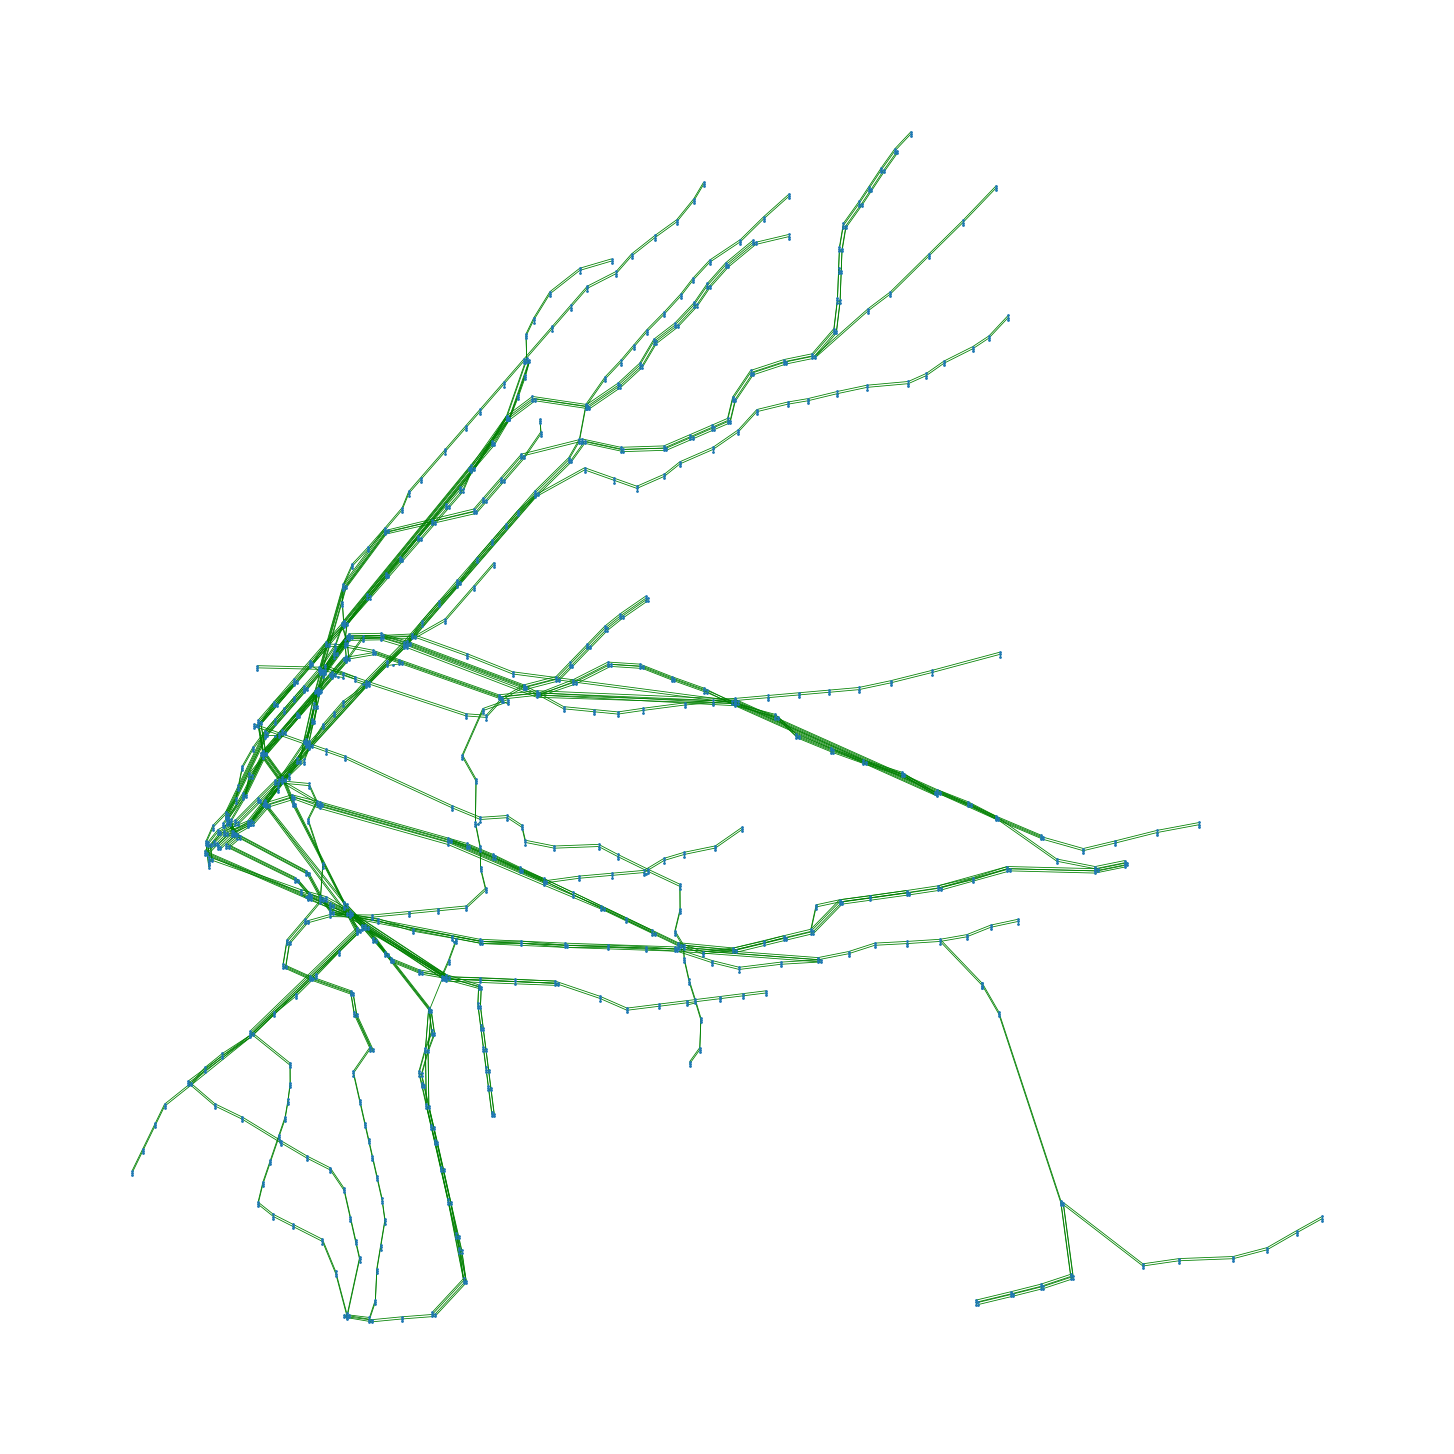

In [50]:
#visualize the subway newtork
plt.figure(figsize = (20,20))
nx.draw(uuNYCSubway,pos=nodePos,with_labels=False,arrows=False,node_size=3,width=0.8,edge_color='green')

In [51]:
#make sure everything is connected
nx.number_connected_components(uuNYCSubway)

1

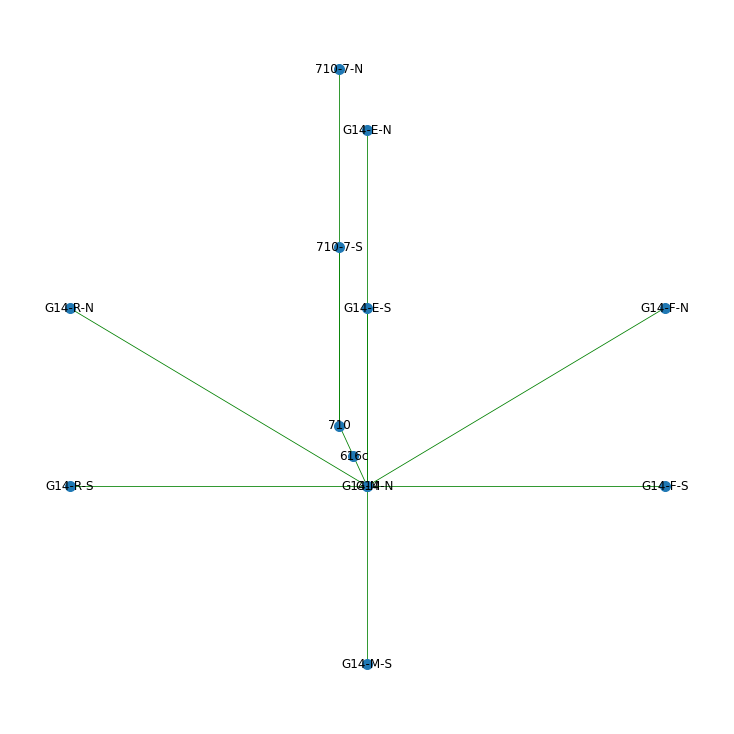

In [52]:
#check a complex to make sure everything looks right -> Jackson Heights: complex ID 616
sg = uuNYCSubway.subgraph(nodes.loc[nodes['Complex ID'] == 616,'node_id'].values)
plt.figure(figsize = (10,10))
nx.draw(sg,pos=nodePos,with_labels=True,arrows=False,node_size=100,width=0.8,edge_color='green')

### Populating the Edge Weights and Calculating Centrality

##### Complex to Station Edges

In [53]:
#First will populate the edge weights for station to complex edges. These weights will signify the time it takes to walk between
#different train platforms in large train stations (e.g. walking betwen the 7 platform and E F M R platforms at Jackson Hts)

#get tuples for every complex to station edge
sc_edge_tup = [tuple(x) for x in complex_edges[['origin','dest']].to_numpy()]

In [54]:
#create empty dictionary, and populate it with the complex to station tuples as the key, and 3 as the value (indicating a 3 minute
#time cost to transfer between stations on these types edges)

sc_edge_dict = {}

for tup in sc_edge_tup:
    sc_edge_dict[tup] = 3

#set edge attributes for complex to station edges using populated dictionary
nx.set_edge_attributes(uuNYCSubway, sc_edge_dict, name = 'travel_time')

##### Station to Station Edge Weights

In [55]:
#Next is to populate the station to station edges, which are for transfers between stations that do not have an assigned complex ID. 
#this is mostly for the new IBX stations that transfer to existing stations, as well as newly constructed transfers that don't have
#an assigned complex ID yet. We will populate these edge weights the same way as for station to complex edges.

ss_edge_tup = [tuple(x) for x in sts_edges[['origin','dest']].to_numpy()]

ss_edge_dict = {}

for tup in ss_edge_tup:
    ss_edge_dict[tup] = 3

#set edge attributes for station to station edges using populated dictionary
nx.set_edge_attributes(uuNYCSubway, ss_edge_dict, name = 'travel_time')

##### Platform to Platform Edge Weights

In [56]:
#next is platform to platform edge weights, which signify the travel times while the train is actually moving. We first need
# train speed data, which will be divided by the geographic distance to get travel time. Train speed data will
#be gathered from the Dec. 2021 GTFS update for the NYC Subway. A package specfically for dealing with GTFS data will be imported
#to get the average train speeds for every train line. 

def get_gtfs_speeds(): 
    import gtfs_functions as gtfs

    routes, stops, stop_times, trips, shapes = gtfs.import_gtfs(r'C:\Users\Rohan\Documents\NYU\ADS\ADS Final Project\nycsubway_gtfs.zip')

    segments_gdf = gtfs.cut_gtfs(stop_times, stops, shapes)

    speeds = gtfs.speeds_from_gtfs(routes, stop_times, segments_gdf, cutoffs=[0,6,9,15,20,24])

    #calculate average speed for every line, dropping ones that aren't modeled by our network
    speeds_by_line = speeds.groupby(['route_id', 'route_name'])['speed_mph'].mean().drop(['ALL_LINES', '6X', '7X', 'FS'])

    #speeds_by_line['IBX'] = 18.67
    speeds_by_line['W'] = speeds_by_line['N'].values[0]

    speeds_by_line = speeds_by_line.reset_index()[['route_id', 'speed_mph']]

    #rename route_ids for joining to the edge list
    speeds_by_line.loc[speeds_by_line['route_id'] == 'FX', 'route_id'] = 'Q'
    speeds_by_line.loc[speeds_by_line['route_id'] == 'H', 'route_id'] = 'S'
    speeds_by_line.loc[speeds_by_line['route_id'] == 'GS', 'route_id'] = 'G'

    return speeds_by_line

#speeds_by_line = get_gtfs_speeds()

speeds_by_line = pd.read_csv('avg_speeds_by_line.csv', index_col=0); speeds_by_line

,route_id,speed_mph
0,1,16.119494
1,2,14.962729
2,3,15.273299
3,4,16.305569
4,5,15.775591
5,6,15.487351
6,7,16.885795
7,A,17.490534
8,B,18.082812
9,C,17.106892


In [57]:
#merge on the list of platform edges
pfs_edges_speeds = pfs_edges_tr.merge(speeds_by_line, how = 'inner', left_on = 'line', right_on = 'route_id'); pfs_edges_speeds

,origin,dest,line,route_id,speed_mph
0,103-1-S,104-1-S,1,1,16.119494
1,103-1-S,101-1-S,1,1,16.119494
2,106-1-S,104-1-S,1,1,16.119494
3,106-1-S,107-1-S,1,1,16.119494
4,108-1-S,109-1-S,1,1,16.119494
...,...,...,...,...,...
1563,R23-W-N,R22-W-N,W,W,15.744100
1564,R24-W-N,R23-W-N,W,W,15.744100
1565,R25-W-N,R24-W-N,W,W,15.744100
1566,R26-W-N,R25-W-N,W,W,15.744100


In [58]:
#import package to calculate geodesic distance between lat/long pairs
from geopy.distance import geodesic

#get list of tuples for platform to platform edges
pp_edge_tup = [tuple(x) for x in pfs_edges_speeds[['origin','dest']].to_numpy()]

#create empty dict
pp_edge_dict = {}

#for every tuple in the list
for tup in pp_edge_tup:
    lon1, lat1 = nodePos.get(tup[0]) #get the node positions
    lon2, lat2 = nodePos.get(tup[1])
    dist = geodesic((lat1, lon1), (lat2, lon2)).miles  #calc distance in miles
    spd = pfs_edges_speeds.loc[pfs_edges_speeds['origin'] == tup[0], 'speed_mph'].values[0] #get the speed of the line (mph)
    pp_edge_dict[tup] = (dist/spd)*60 #calc time in minutes

In [59]:
#set the edge attributes using the populated dictionary
nx.set_edge_attributes(uuNYCSubway, pp_edge_dict, name = 'travel_time')

##### Station to Platform Edge Weights

In [60]:
#next is station to platform edges, which signify the train frequencies or headways (i.e. how long a person has to wait at 
# a platform for the next train to come). Headways vary wildly depending on if its peak or off-peak service hours. At peak hours,
#average headways are 2-5 minutes. At off-peak hours, average headways are 10-20 minutes. To be conservative, we will
#set the peak headways to be 5 minutes, and the off-peak headways to be 15 minutes 

#first need to make a copy of the existing graph, and set one to be the peak hours graph, and one to be the off-peak graph
uuNYCSubway_peak = uuNYCSubway.copy()

uuNYCSubway_offpeak = uuNYCSubway.copy()

uuNYCSubway_peak.graph['time'] = 'peak'

uuNYCSubway_offpeak.graph['time'] = 'offpeak'

In [61]:
#get list of tuples for every station to platform edge
sp_edge_tup = [tuple(x) for x in stpf_edges[['origin','dest']].to_numpy()]

sp_edge_dict_peak = {}
sp_edge_dict_offpeak = {}

#populate the peak/offpeak dictionaries with their respective headways, in minutes
for tup in sp_edge_tup:
    sp_edge_dict_peak[tup] = 5
    sp_edge_dict_offpeak[tup] = 15

In [62]:
#set the edge attributes for the two separate graphs
nx.set_edge_attributes(uuNYCSubway_peak, sp_edge_dict_peak, name = 'travel_time')
nx.set_edge_attributes(uuNYCSubway_offpeak, sp_edge_dict_offpeak, name = 'travel_time')

##### Centrality Scores

In [65]:
#peak closeness centrality
peak_centrality_scores = pd.DataFrame.from_dict(nx.closeness_centrality(
    uuNYCSubway_peak, distance='travel_time'), 
    orient = 'index', 
    columns = ['closeness_centrality'])

In [68]:
#offpeak closeness centrality
offpeak_centrality_scores = pd.DataFrame.from_dict(nx.closeness_centrality(
    uuNYCSubway_offpeak, distance='travel_time'), 
    orient = 'index', 
    columns=['closeness_centrality'])

In [70]:
def extract_main_nodes(df):

    #extracts the main station node labels and complex IDs (w/o the platform and line labels), 
    # as those are the only that matter for aggregation purposes

    from itertools import chain

    #df.index = df.index.map(lambda x: str(x))

    main_sta_nodes = list(chain.from_iterable([x for x in df.index.str.split('-').to_list() if len(x) == 1]))

    df = df.loc[df.index.isin(main_sta_nodes)]

    return df.loc[df.index.isin(nodes_export['node_id'].values)]

In [71]:
peak_centrality_scores = extract_main_nodes(peak_centrality_scores)
offpeak_centrality_scores = extract_main_nodes(offpeak_centrality_scores)

In [212]:
peak_centrality_scores.to_csv('ctrl_scrs_sta_noIBX_peak.csv')
offpeak_centrality_scores.to_csv('ctrl_scrs_sta_noIBX_offpeak.csv')

Text(0.5, 1.0, 'Top 50, Brooklyn and Queens Only')

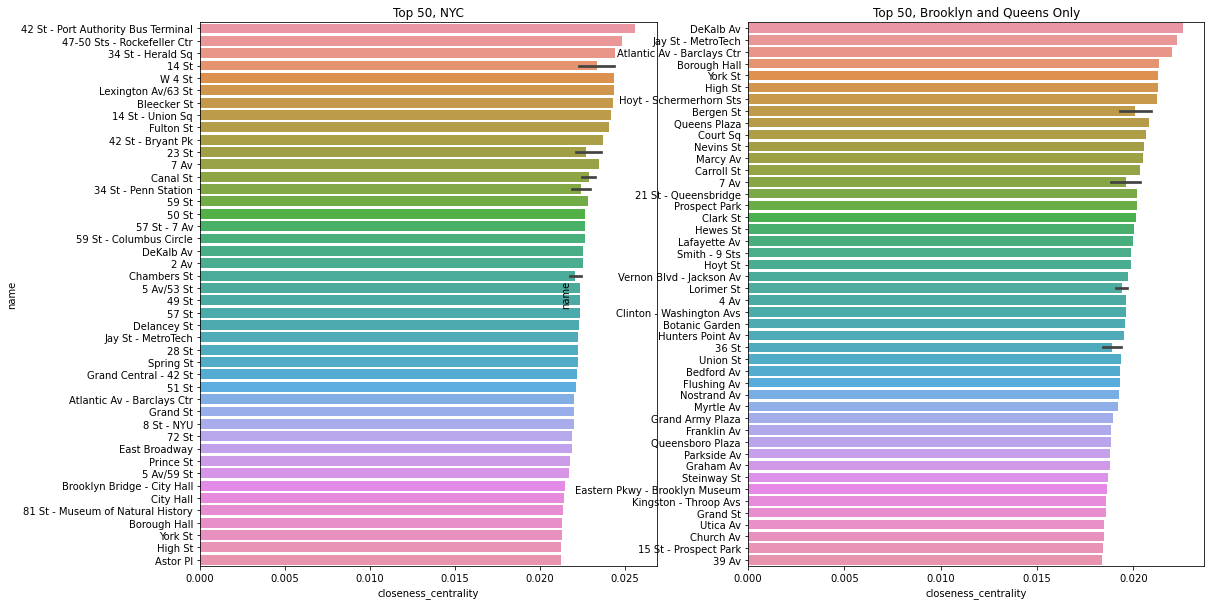

In [69]:
import seaborn as sns

scores_name = peak_centrality_scores.merge(nodes_export.loc[:,['name', 'node_id', 'boro']], left_index=True, right_on='node_id')

top_50_scores = scores_name.sort_values(by = 'closeness_centrality', ascending=False)[:50]

bk_q_scores = scores_name.loc[(scores_name['boro'] == 'Bk') | (scores_name['boro'] == 'Q')] \
    .sort_values(by = 'closeness_centrality', ascending=False)[:50]

fig, axes = plt.subplots(1,2, figsize = (18,10))
sns.barplot(x = 'closeness_centrality', y = 'name', data = top_50_scores, ax=axes[0])
axes[0].set_title('Top 50, NYC')
sns.barplot(x = 'closeness_centrality', y = 'name', data = bk_q_scores, ax = axes[1])
axes[1].set_title('Top 50, Brooklyn and Queens Only')

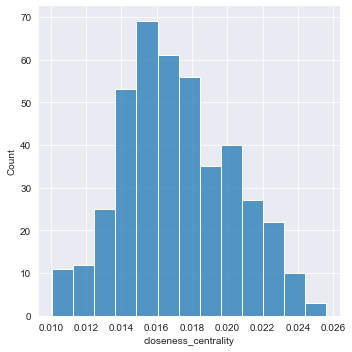

In [71]:
sns.set_style('darkgrid')
sns.displot(data = peak_centrality_scores, x = 'closeness_centrality', kind = 'hist')

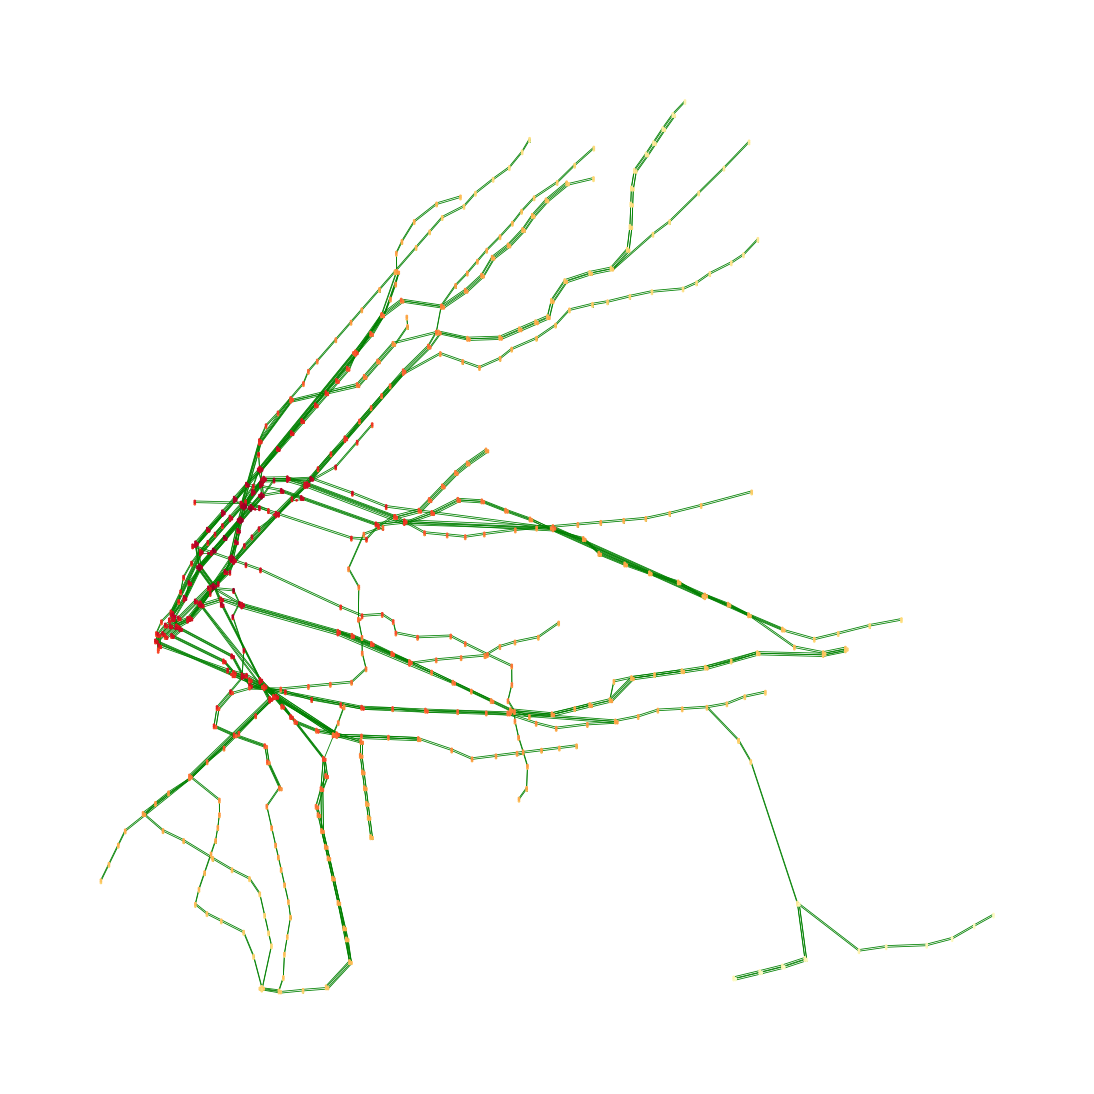

In [67]:
plt.figure(figsize = (15,15))
nx.draw(uuNYCSubway_peak,pos=nodePos,with_labels=False,arrows=False,node_size=3,width=0.8,edge_color='green', 
node_color = peak_centrality_scores.values, cmap = 'YlOrRd')

### Diagnostics and Troubleshooting

In [63]:
#auxiliary function - visualize path on the map
def visualize_path(G, o, d):
    path = nx.shortest_path(G, o, d, weight = 'travel_time')
    print(path)
    print('Travel time: ', nx.shortest_path_length(G, o, d, weight='travel_time'), 'mins')

    plt.figure(figsize = (10,10))
    nx.draw(uuNYCSubway,pos=nodePos,with_labels=False,arrows=False,node_size=1,width=1,edge_color='green')
    x=[nodePos[v][0] for v in path]
    y=[nodePos[v][1] for v in path]
    plt.plot(x,y,'ro-')
    plt.plot([x[0],x[-1]],[y[0],y[-1]],'bs',markersize=10)

['L20', 'L20-L-N', 'L21-L-N', 'L22-L-N', 'L24-L-N', 'L25-L-N', 'L26-L-N', 'L26', '254', '254-3-N', '253-3-N', '252-3-N', '251-3-N', '250-3-N', '239-3-N', '239', '626c', 'S04', 'D26', 'D26-B-S', 'D28-B-S', 'D31-B-S', 'D32-B-S', 'D33-B-S', 'D33']
Travel time:  68.81074981575702 mins


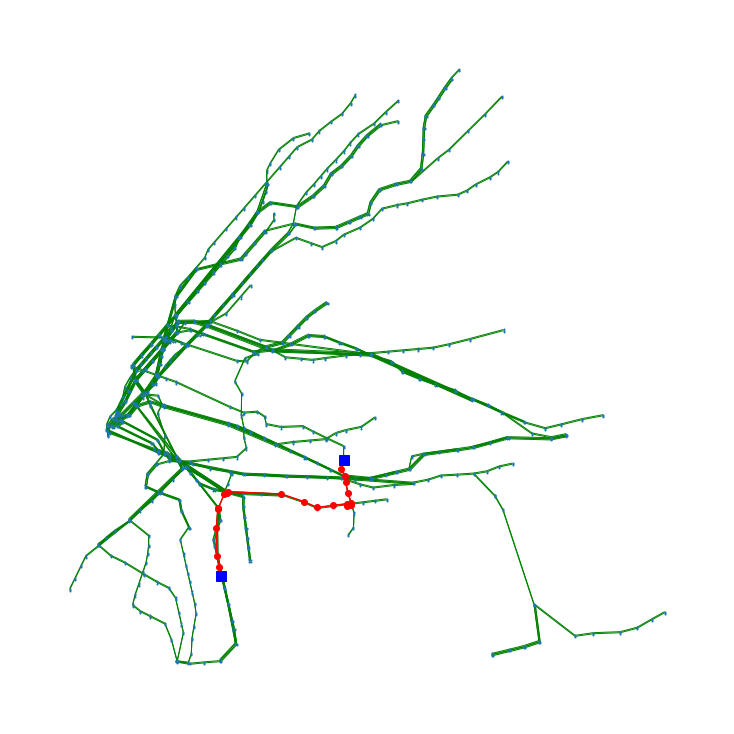

In [64]:
visualize_path(uuNYCSubway_peak, 'L20', 'D33')

In [ ]:
#check that each line is a single component. The S line includes the rockaway shuttle, franklin shuttle, and 42nd st shuttle
for l in nodes.loc[nodes['pf_id'] != 'station','line_'].unique():
    lgr=nx.Graph()
    for i in edges.index:
        if edges.loc[i,'line'] == l:
            lgr.add_edge(edges.origin[i],edges.dest[i])  
    cc = nx.number_connected_components(lgr)
    print(f'{l} line has {cc} components')

1 line has 1 components
2 line has 1 components
3 line has 1 components
5 line has 1 components
4 line has 1 components
6 line has 1 components
7 line has 1 components
S line has 3 components
A line has 1 components
C line has 1 components
B line has 1 components
D line has 1 components
E line has 1 components
F line has 1 components
G line has 1 components
Q line has 1 components
M line has 1 components
IBX line has 1 components
N line has 1 components
J line has 1 components
Z line has 1 components
R line has 1 components
L line has 1 components
W line has 1 components
SIR line has 1 components


In [ ]:
#use this function to check that none of the lines has gaps/missing edges
lgr=nx.Graph()
for i in edges.index:
    if edges.loc[i,'line'] == 'Z':
        lgr.add_edge(edges.origin[i],edges.dest[i])  

for c in nx.connected_components(lgr):
    print(c)

plt.figure(figsize = (30,30))
nx.draw(lgr,pos=nodePos,with_labels=True,arrows=False,node_size=3,width=0.8,edge_color='green')